<a href="https://colab.research.google.com/github/K-Domar/MyRepo/blob/main/Diamond_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense
from keras.models import Sequential

**Content**

*price* - price in US dollars (\$326--\$18,823)

*carat* - weight of the diamond (0.2--5.01)

*cut* - quality of the cut (Fair, Good, Very Good, Premium, Ideal)

*color* - diamond colour, from J (worst) to D (best)

*clarity* -  a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

*x* - length in mm (0--10.74)

*y* - width in mm (0--58.9)

*z* - depth in mm (0--31.8)

*depth* - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

*table* - width of top of diamond relative to widest point (43--95)

In [250]:
diamond = pd.read_csv('https://raw.githubusercontent.com/K-Domar/MyRepo/main/diamonds.csv')
diamond = diamond.loc[:,~diamond.columns.str.match("Unnamed")]
diamond.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [251]:
diamond.describe()
diamond.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

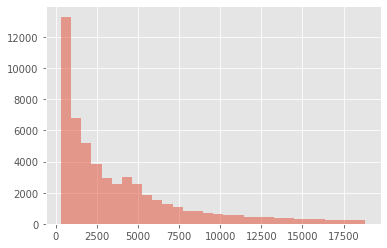

In [239]:
# Plot a histogram
diamond.price.hist(bins=30, alpha=0.5)
plt.show()

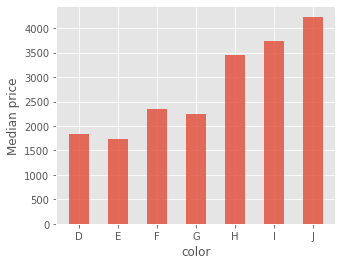

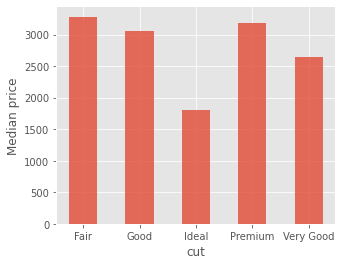

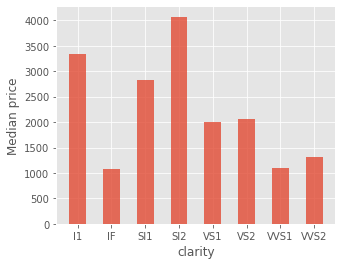

In [214]:
plt.style.use('ggplot')
names = ['color', 'cut', 'clarity']
# EDA for categorical features 

for i in range(0,3):
  
  parameters = diamond.groupby(names[i], as_index=False)['price'].median()
  fig = plt.figure(figsize=(5, 4))
  plt.bar(parameters[names[i]], parameters.price, width=0.5, alpha=0.8)
  plt.xlabel(names[i])
  i += 1
  plt.ylabel('Median price')
plt.show()

In [215]:
#fig2, axes = plt.subplots(nrows=4, ncols=7)
#for i, ax in enumerate(axes.flatten()):
    #df[df.columns[i]].plot(color=colors[i], ax=ax)
    #ax.set_title(df.columns[i])

In [252]:
#Feature Engineering

#One_Hot encoding

ohe_cut = pd.get_dummies(diamond['cut'], prefix='cut')
ohe_color = pd.get_dummies(diamond['color'], prefix='color')
ohe_clarity = pd.get_dummies(diamond['clarity'], prefix='clarity')

diamond= pd.concat([diamond, ohe_cut], axis=1)
diamond= pd.concat([diamond, ohe_color], axis=1)
diamond= pd.concat([diamond, ohe_clarity], axis=1)

#drop colums with type 'object'
diamond = diamond.select_dtypes(exclude=['object'])
diamond.shape

(53940, 27)

In [ ]:
X = diamond.drop('price', axis=1)
y = diamond['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


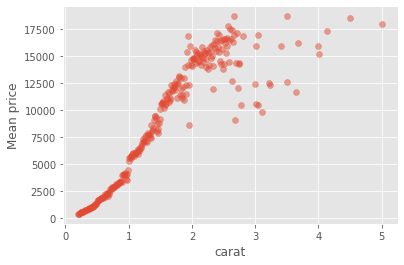

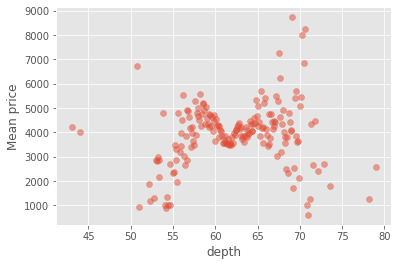

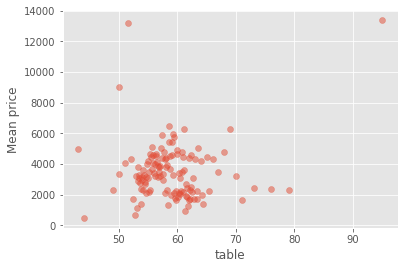

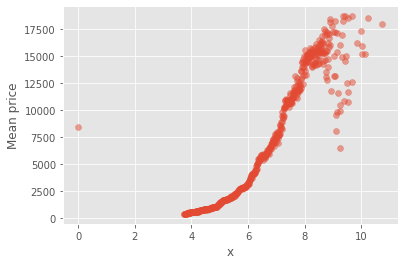

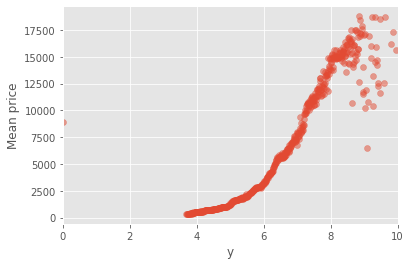

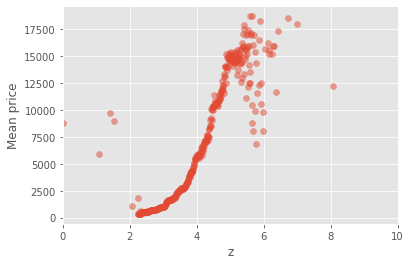

In [256]:
# EDA for numerical features

name = ['carat', 'depth', 'table', 'x', 'y', 'z']

for i in range(0,6):
  num_parameters = diamond.groupby(name[i], as_index=False)['price'].mean()
  plt.scatter(x=num_parameters[name[i]], y=num_parameters['price'], alpha=0.5)

  plt.xlabel(name[i])
  plt.ylabel('Mean price')
  if i > 3:
    plt.xlim(0, 10)
  plt.show()

In [258]:
# Simple Classifieres
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_predicted = rf.predict(X_test)
rmse = np.sqrt(MSE(y_test, y_predicted))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 566.8210996543993


In [260]:
print("Score train = ",rf.score(X_train, y_train))
print("Score test  = ",rf.score(X_test, y_test))

Score train =  0.9973015079744787
Score test  =  0.9806016656780058
